In [2]:
# Magic line to force reload all modules when this cell is run multiple times
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [3]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [4]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history, plot_3d_lrp
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [6]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [7]:
raw_data.shape

(325, 335)

In [8]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [9]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [10]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"
HR = labels["Risk"]=="HR"

In [11]:
LR_typical = labels[LR & typical]
HR_ASD = labels[HR & ASD]

# ASD vs LR_Typical

In [13]:
analysis_labels = pd.concat((LR_typical, HR_ASD))
analysis_labels["Risk"].value_counts()

LR    99
HR    39
Name: Risk, dtype: int64

In [14]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR', 'LR'], dtype=object)]

In [15]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

(110, 333)


1    79
0    31
dtype: int64

In [21]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)

    dnn.add(Dense(units = 64, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2)),
    dnn.add(Dense(units = 64, activation=activation,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_regularizer=my_reg)) # 5 labels -> logits for now
    
#     SGD=keras.optimizers.SGD(lr=0.001)
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [31]:
# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [32]:
risk_labels.value_counts()

1    99
0    39
dtype: int64

In [33]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [34]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Pool...
Initialized Pool...
Runtime: 394.284s
Correct: 98
Test Size: 138
Confusion matrix, without normalization
[[0.48717949 0.51282051]
 [0.2020202  0.7979798 ]]
Overall Accuracy: 0.7101
Loading LRP Analyzers...
Done!


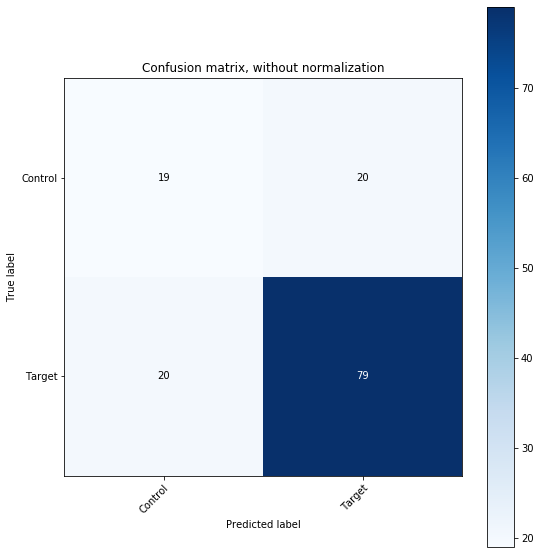

In [35]:
cm = pipeline.train_model(batch_size=int(10), epochs=5000, cross_validation=True,
                          parallel=True, verbose=0, smote=True)

In [36]:
correct_ASD = cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(cm,axis=0)[0]))

Sensitivity: 0.4872
PPV: 0.4872


# Check sample IDs

In [142]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]
correct_HR

,ASD_DX_group,Risk
CandID,,
172993,ASD,HR
402809,ASD,HR
930203,ASD,HR
983222,ASD,HR
809318,ASD,HR
812857,ASD,HR
490878,ASD,HR
751794,ASD,HR
336576,ASD,HR


In [140]:
# smote_dbl_cws = cm.copy()
print(smote_dbl_cws)
correct_ASD = smote_dbl_cws[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(smote_dbl_cws,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(smote_dbl_cws,axis=0)[0]))

[[18 21]
 [18 81]]
Sensitivity: 0.4615
PPV: 0.5000


## SMOTE + Class Weights

In [130]:
# smote_cws_cm = cm.copy()
print(smote_cws_cm)
correct_ASD = smote_cws_cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(smote_cws_cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(smote_cws_cm,axis=0)[0]))

[[18 21]
 [18 81]]
Sensitivity: 0.4615
PPV: 0.5000


## Double Class Weight for ASD

In [127]:
# elu_cm = cm.copy()
print(elu_cm)
correct_ASD = elu_cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(elu_cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(elu_cm,axis=0)[0]))

[[16 23]
 [16 83]]
Sensitivity: 0.4103
PPV: 0.5000


In [128]:
# relu_cm = cm.copy()
print(relu_cm)
correct_ASD = relu_cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(relu_cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(relu_cm,axis=0)[0]))

[[14 25]
 [15 84]]
Sensitivity: 0.3590
PPV: 0.4828
